In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

# Load data

In [2]:
engine1 = pd.read_csv("UIPA.HMD8310H.Engine1.csv")
engine2 = pd.read_csv("UIPA.HMD8310H.Engine2.csv")

/tmp/ipykernel_1564793/1235946815.py:1: DtypeWarning: Columns (152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,3

In [3]:
engine1["battery_only"] = engine1["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)
engine2["battery_only"] = engine2["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)

In [4]:
merged_df = pd.merge(engine1[["aIEngineLoad", "time", "battery_only"]], engine2[["aIEngineLoad", "time"]], on='time', how='inner')
merged_df["total_load"] = merged_df["aIEngineLoad_x"] + merged_df["aIEngineLoad_y"]
merged_df_all_columns = pd.merge(engine1, engine2, on='time', how='inner')
merged_df_all_columns["total_load"] = merged_df_all_columns["aIEngineLoad_x"] + merged_df_all_columns["aIEngineLoad_y"]

In [5]:
mgo = pd.read_csv("RemoteLevelThing_HMD8310.csv")
mgo["total_vol"] = mgo["MGO_STOR_TK_C_CALC_VOL"] + mgo["MGO_STOR_TK_S_CALC_VOL"] + mgo["NO1_MGO_SERV_TK_CALC_VOL"] + mgo["NO2_MGO_SERV_TK_CALC_VOL"]

/tmp/ipykernel_1564793/3850218066.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  mgo = pd.read_csv("RemoteLevelThing_HMD8310.csv")


In [6]:
engine_and_fuel_df = pd.merge(merged_df, mgo[["total_vol", "time"]], on='time', how='inner')
engine_and_fuel_df_all_columns = pd.merge(merged_df_all_columns, mgo[["total_vol", "time"]], on='time', how='inner')

# Find useful segments

In [7]:
numeric_columns = engine_and_fuel_df_all_columns.select_dtypes(include=['number'])
numeric_columns["total_vol_diff"] = numeric_columns["total_vol"].diff()
numeric_columns["total_vol_diff"].iloc[:-1] = numeric_columns["total_vol_diff"].iloc[1:].values
corr = numeric_columns.corr()

/tmp/ipykernel_1564793/2805894286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_columns["total_vol_diff"].iloc[:-1] = numeric_columns["total_vol_diff"].iloc[1:].values


In [8]:
print(corr["total_vol_diff"].sort_values(ascending=False)[:5])
print(corr["total_vol_diff"].sort_values(ascending=True)[:5])

total_vol_diff                                  1.000000
aICyclicSlowTurningState_y                      0.008492
aICyclicSlowTurningState_x                      0.004630
aITimeRemainingForNextCyclicSlowTurningSec_x    0.003461
aIModbusHeartbeatCounter_y                      0.003421
Name: total_vol_diff, dtype: float64
total_vol                                      -0.051304
aITimeRemainingForNextCyclicSlowTurningMin_y   -0.017514
aIKnockKnockIntensityCylinderA07_y             -0.014379
aIDurationOffsetPilotInjectionCylinderA05_y    -0.004995
aIKnockKnockIntensityCylinderA07_x             -0.004850
Name: total_vol_diff, dtype: float64


In [9]:
fuel_noise_start_points = [1750, 10000, 29500, 35400, 85500]
fuel_noise_end_points = [9300, 17800, 32200, 48100, 88500]

segments = []

for noise_start_point, noise_end_point in zip(fuel_noise_start_points, fuel_noise_end_points):
    segment = engine_and_fuel_df_all_columns.loc[noise_start_point:noise_end_point].copy()
    segment.reset_index(drop=True, inplace=True)
    segments.append(segment)

In [10]:
for column in segments:
    try:
        segments[column] = pd.to_numeric(segments[column])
    except:
        pass

In [202]:
bool_data_segments = []
original_segments = []
continuous_data_segments = []


for segment in segments:
    # Create a numerical index for grouping
    numeric_data = segment.select_dtypes(include=['number']).copy()
    mask = segments[0].columns.str.startswith("dI")
    bool_columns = segments[0].columns[mask]
    bool_data = segment.loc[:, bool_columns]
    # numeric_data.loc[:numeric_data.shape[0]-2, "total_vol_diff"] = numeric_data["total_vol"].diff().values[1:]

    rolling_mean = numeric_data.rolling(100).mean()
    rolling_mean.dropna(inplace=True)

    # Find monotonically decreasing segment
    tmp = rolling_mean.copy()
    mono_dec_new_segment = pd.DataFrame(columns=tmp.columns)
    min_value = tmp.loc[tmp.index[0], "total_vol"]
    for idx, row in tmp.iterrows():
        if row["total_vol"] < min_value:
            mono_dec_new_segment.loc[idx] = row
            min_value = row["total_vol"]

    bool_data = bool_data.loc[mono_dec_new_segment.index, :]
    bool_data.dropna(inplace=True)
    bool_data = bool_data.astype(int)
    mono_dec_new_segment = mono_dec_new_segment.loc[bool_data.index, :]
    bool_data.reset_index(drop=True, inplace=True)
    mono_dec_new_segment.reset_index(drop=True, inplace=True)
    mono_dec_new_segment.loc[:mono_dec_new_segment.shape[0]-2, "total_vol_diff"] = mono_dec_new_segment["total_vol"].diff().values[1:]
    bool_data["total_vol_diff"] = mono_dec_new_segment["total_vol_diff"]
    bool_data_segments.append(bool_data)
    continuous_data_segments.append(mono_dec_new_segment)

In [309]:
bool_data_segments = []
original_segments = []
continuous_data_segments = []


for segment in segments:
    # Create a numerical index for grouping
    numeric_data = segment.select_dtypes(include=['number']).copy()
    mask = segments[0].columns.str.startswith("dI")
    bool_columns = segments[0].columns[mask]
    bool_data = segment.loc[:, bool_columns]
    # numeric_data.loc[:numeric_data.shape[0]-2, "total_vol_diff"] = numeric_data["total_vol"].diff().values[1:]

    rolling_mean = numeric_data.rolling(100).mean()
    rolling_mean.dropna(inplace=True)

    # Find monotonically decreasing segment
    tmp = rolling_mean.copy()
    mono_dec_new_segment = pd.DataFrame(columns=tmp.columns)
    min_value = tmp.loc[tmp.index[0], "total_vol"]
    for idx, row in tmp.iterrows():
        if row["total_vol"] < min_value:
            mono_dec_new_segment.loc[idx] = row
            min_value = row["total_vol"]

    bool_data = bool_data.loc[mono_dec_new_segment.index, :]
    # bool_data.dropna(axis=1, inplace=True)
    # bool_data = bool_data.astype(int)
    mono_dec_new_segment = mono_dec_new_segment.loc[bool_data.index, :]
    bool_data.reset_index(drop=True, inplace=True)
    mono_dec_new_segment.reset_index(drop=True, inplace=True)
    mono_dec_new_segment["total_vol_diff"] = mono_dec_new_segment["total_vol"].diff(-1)
    bool_data["total_vol_diff"] = mono_dec_new_segment["total_vol_diff"]
    bool_data_segments.append(bool_data)
    continuous_data_segments.append(mono_dec_new_segment)

<AxesSubplot: >

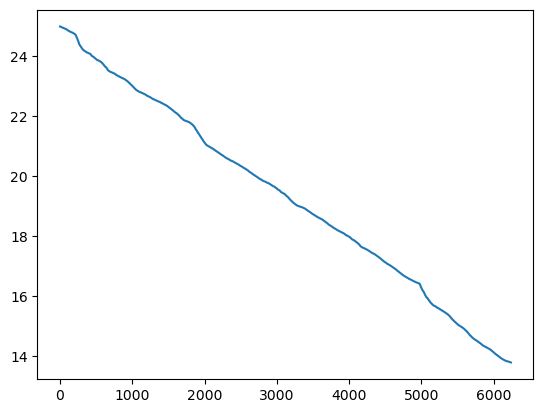

In [243]:
mono_dec_new_segment["total_vol"].plot()

In [322]:
segments[4].isna().sum().sort_values()

Unnamed: 0_x                                       0
dICylinderPressSensorFailureCylA08Alarm_y          0
dICylinderPressSensorFailureCylA07Alarm_y          0
dICylinderPressSensorFailureCylA06Alarm_y          0
dICylinderPressSensorFailureCylA05Alarm_y          0
                                                  ..
dIHTTempJacketOutletHighSD_x                       0
dIHTTempJacketOutletHighFromISMSD_x                0
dIHTTempJacketOutletHigh2Alarm_x                   0
dIIOExtensionModuleFailureAIO204SI11KA06Alarm_x    0
total_vol                                          0
Length: 1407, dtype: int64

In [310]:
mask = segment.isna().sum()>10
has_nans = segment.loc[:, segment.columns[mask.values]]
idx_nans = has_nans[has_nans.isna().iloc[:, 0]].index
idx_nans

IndexError: single positional indexer is out-of-bounds

<AxesSubplot: >

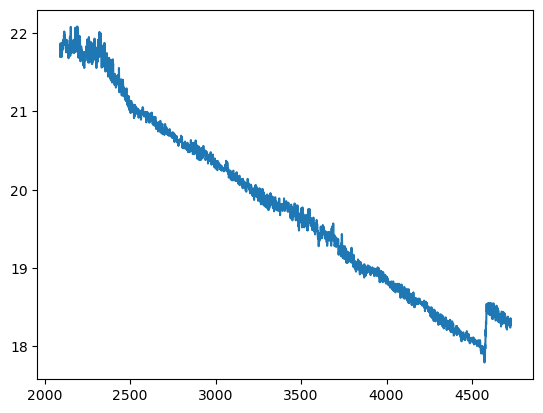

In [ ]:
segment.loc[idx_nans, "total_vol"]

<AxesSubplot: >

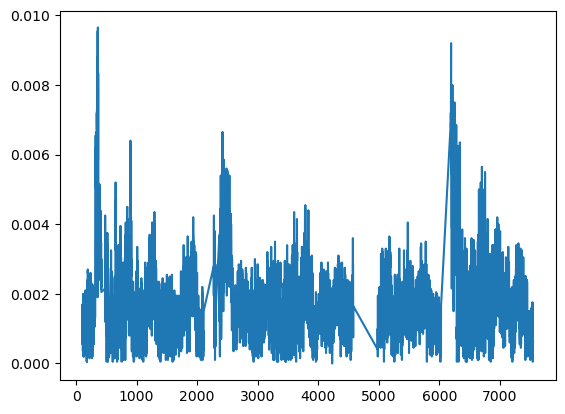

In [225]:

mono_dec_new_segment["total_vol_diff"].plot()

<AxesSubplot: >

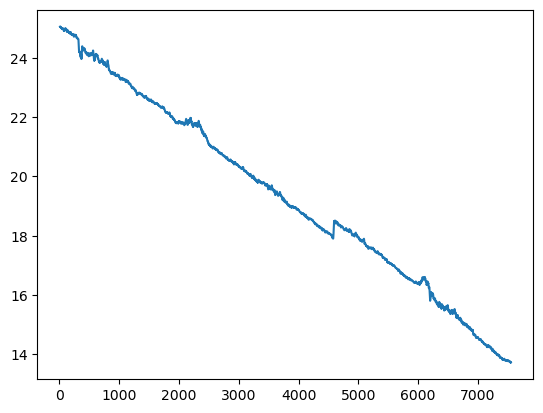

In [216]:
rolling_mean["total_vol"].plot()

<AxesSubplot: >

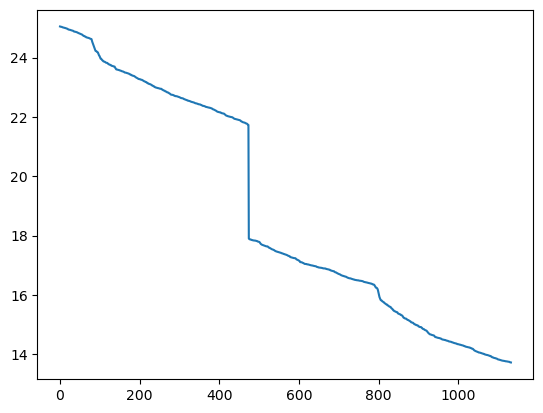

In [209]:
mono_dec_new_segment["total_vol"].plot()

<AxesSubplot: >

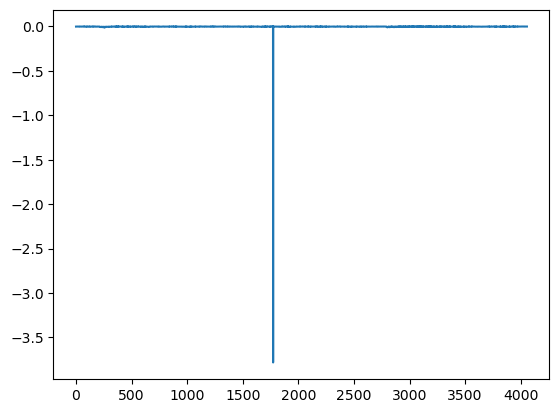

In [203]:
continuous_data_segments[0]["total_vol_diff"].plot()

In [195]:
rolling_mean = segments[0]["total_vol"].rolling(100).mean()
tmp = pd.DataFrame(rolling_mean.copy())
mono_dec_new_segment = pd.DataFrame(columns=tmp.columns)
for idx, row in tmp.iterrows():
    if row["total_vol"] < min_value:
        mono_dec_new_segment.loc[idx] = row
        min_value = row["total_vol"]

<AxesSubplot: >

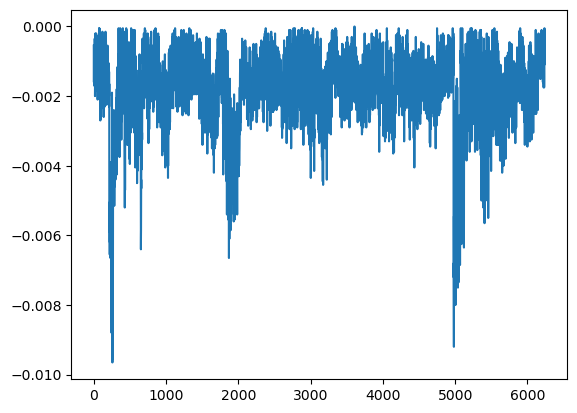

In [201]:
mono_dec_new_segment.reset_index(drop=True, inplace=True)
mono_dec_new_segment.loc[:mono_dec_new_segment.shape[0]-2, "total_vol_diff"] = mono_dec_new_segment["total_vol"].diff().values[1:]
mono_dec_new_segment["total_vol_diff"].plot()

<AxesSubplot: >

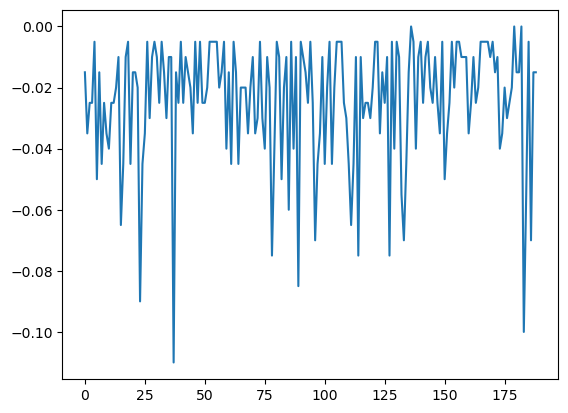

In [181]:
mono_dec_new_segment["total_vol_diff"].plot()

<AxesSubplot: >

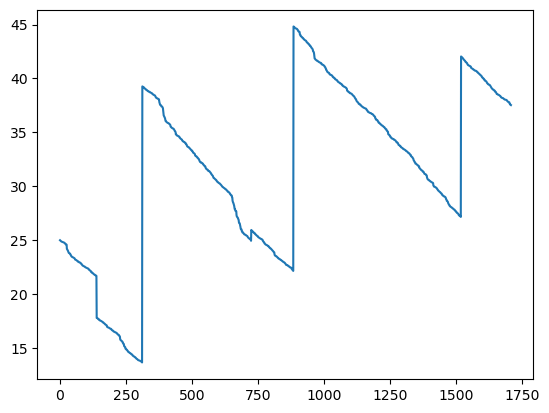

In [178]:
continuous_df = pd.concat(continuous_data_segments)
continuous_df.reset_index(drop=True, inplace=True)
continuous_df["total_vol"].plot()

In [94]:
categorical_df = pd.concat(bool_data_segments)
categorical_df.reset_index(drop=True, inplace=True)
categorical_df.shape

(23902, 1097)

In [95]:
all_features_df = pd.concat([continuous_df, categorical_df], axis=1)
# Drop duplicated columns
all_features_df = all_features_df.loc[:,~all_features_df.columns.duplicated()].copy()
# Drop useless columns
all_features_df = all_features_df.loc[:,~all_features_df.columns.str.startswith('Unnamed')].copy()

In [112]:
nan_rows = all_features_df.isna().any(axis=0)
all_features_df.loc[:, nan_rows].isna().sum()

total_vol_diff    5
dtype: int64

In [116]:
# Drop NANs from df
all_features_df.dropna(inplace=True)
categorical_df.dropna(inplace=True)
continuous_df.dropna(inplace=True)
print(continuous_df.shape)
print(categorical_df.shape)
print(continuous_df.shape)

(23897, 309)
(23897, 1097)
(23897, 309)


# Predicting the fuel consumption

## Feature Selection

In [153]:
# Using f-regression
from sklearn.feature_selection import f_regression

def make_results_df(bool_data):
    categorical_columns = bool_data.columns[:-1]
    dependent_variable = bool_data.columns[-1]
    results_df = pd.DataFrame(index=categorical_columns)
    f, p_val = f_regression(bool_data[categorical_columns],bool_data[dependent_variable])
    results_df.loc[categorical_columns, "f-statistic"] = f
    results_df.loc[categorical_columns, "p-value"] = p_val
    return results_df

cat_results_df = make_results_df(categorical_df.drop("total_vol_diff", axis=1))

In [155]:
cat_results_df.sort_values(by="p-value")[:10]

,f-statistic,p-value
dILoadLowAtDieselBackupModeAlarm_y,2944.961674,0.000000e+00
dIPilotFuelOilInjectionTestResult02Event_y,907.991812,8.249733e-196
dIGasLeakCheckResult01Event_x,829.370167,2.564347e-179
dIGasLeakCheckResult02Event_x,828.938979,3.159199e-179
dIReadyToStartEvent_x,467.062348,1.341867e-102
dIEngineStoppedEvent_x,455.605801,3.746398e-100
dIEngineIsRunningEvent_x,455.003945,5.036654e-100
dIEnableActuatorEvent_x,454.488520,6.489564e-100
dIDegassingValveACLOSEDPositionFeedbackEvent_x,454.402656,6.769439e-100
dIPilotFuelOilInjectionTestResult02Event_x,453.887716,8.720179e-100


In [160]:
topk = 10
top_columns = cat_results_df.sort_values(by="p-value")[:topk].index

In [161]:
X_cat = categorical_df[top_columns]
y_cat = categorical_df["total_vol_diff"]
X_train, X_test, y_train, y_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

<AxesSubplot: >

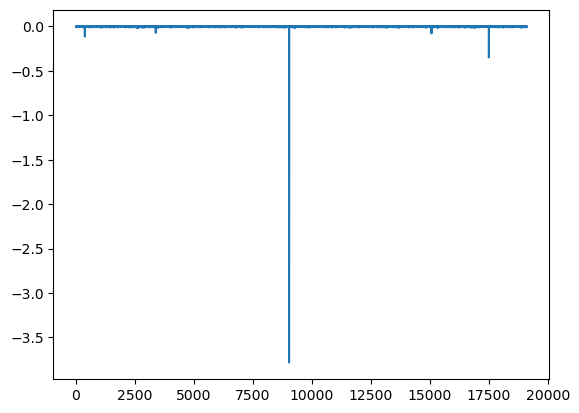

In [168]:
y_train.reset_index(drop=True).plot()

In [162]:
# Training the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
y_pred = y_pred.clip(0)
mse = mean_absolute_error(y_test, y_pred)
print("Mean absolute Error:", mse)

Mean absolute Error: 0.0021237343096234024


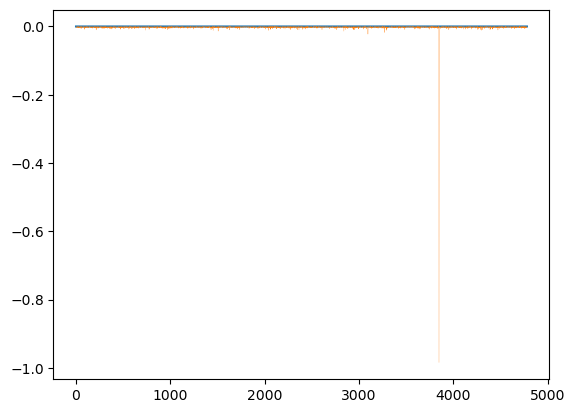

In [163]:
plt.plot(y_pred)
plt.plot(y_test.reset_index(drop=True), linewidth=0.2)

In [164]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.001171358437558866


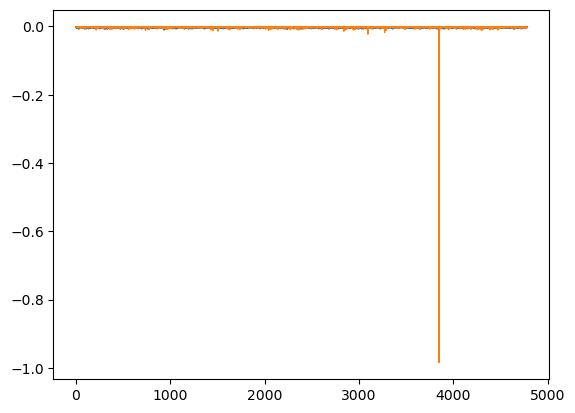

In [165]:
plt.plot(y_pred)
plt.plot(y_test.reset_index(drop=True), linewidth=1)

In [75]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0008915439330543934


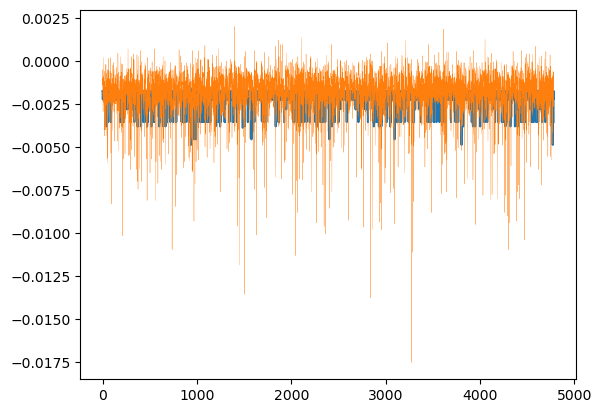

In [78]:
plt.plot(y_pred)
plt.plot(y_test.reset_index(drop=True), linewidth=0.2)

## PCA

In [48]:
from sklearn.decomposition import PCA

from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [55]:
y = all_features_df["total_vol_diff"]
X = all_features_df.drop("total_vol_diff", axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=0.75)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [57]:
# Training the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0008305551596661713


In [58]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0005752775104602518


In [59]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0005919330543933069


## Using only continuous values

In [22]:



# Define the Neural Network
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)  # Increased number of neurons
        self.bn1 = nn.BatchNorm1d(64)           # Batch normalization
        self.dropout1 = nn.Dropout(0.2)         # Dropout
        self.fc3 = nn.Linear(64, 1)             # 2 inputs, 1 output

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc3(x)
        return x

def net_pipeline(X_train, y_train, X_test, y_test, epochs):
    net = Net(X_train.shape[1])

    # Define the Loss Function and Optimizer
    criterion = nn.MSELoss()
    # optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)
    # optimizer = optim.Adadelta(net.parameters()) # 0.02
    # optimizer = optim.Adagrad(net.parameters()) # 0.0018
    # optimizer = optim.AdamW(net.parameters()) # 0.0008
    # optimizer = optim.SparseAdam(net.parameters()) # Doesnt work
    # optimizer = optim.Adamax(net.parameters()) #0.002
    # optimizer = optim.ASGD(net.parameters()) # 0.00077
    # optimizer = optim.NAdam(net.parameters()) # 0.00078
    # optimizer = optim.RAdam(net.parameters()) #  0.00077
    # optimizer = optim.RMSprop(net.parameters()) # 0.0049
    optimizer = optim.Rprop(net.parameters()) # 0.00072
    # optimizer = optim.SGD(net.parameters(), lr=0.01) # 0.00077

    # Example Data (you will replace this with your actual data)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert X to a PyTorch tensor
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Convert y to a PyTorch tensor
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert X to a PyTorch tensor
    inputs = X_train_tensor
    targets = y_train_tensor

    # Training the Network
    for epoch in range(epochs):  # number of times to loop over the dataset
        optimizer.zero_grad()   # zero the parameter gradients
        outputs = net(inputs)   # forward pass
        loss = criterion(outputs, targets) # calculate the loss
        loss.backward()         # backward pass
        optimizer.step()        # optimize

        if epoch % 10 == 0:    # print every 100 epochs
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    with torch.no_grad():
        test_input = X_test_tensor # Example voltage input
        predicted = net(test_input)
        mae = mean_absolute_error(y_test, predicted)
        mape = mean_absolute_percentage_error(y_test, predicted)
    return mae, mape

# net_pipeline(X_train_, y_train_.values.reshape(-1,1), X_test_, y_test_.values.reshape(-1,1), epochs=20000)

In [191]:
# We will use only the monotonically decreasing segments cuz increasing fuel values don't make sense
models_list = ["lr", "lasso", "ridge", "bayesian_ridge", "elasticnet", "DT", "RF", "xgb", "lgbm", "gpr", "knr", "svr", "kernel_ridge", "lars", "lassolars", "NN"]
feat_sel_methods = ["corr", "rfr", "gbr", "combined"]
topk = 15
parameters = list(product(models_list, feat_sel_methods))
results_df = pd.DataFrame(index=models_list) # For mae
results_list = [] # (model_name, mae, preds)
mape_df = pd.DataFrame(index=models_list) # For mae

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for model_name, feat_sel_method in parameters:
    if (feat_sel_method=="corr"):
        corr = corrs_df
        selected_negative_features = list(corr.sort_values(by="total_vol_diff")[:topk].index)
        selected_positive_features = list(corr.sort_values(by="total_vol_diff", ascending=False)[:topk].index)
        selected_features_continuous = list(set(selected_negative_features+selected_positive_features))
    elif feat_sel_method=="rfr":
        selected_features_continuous = selected_features_rf
    elif feat_sel_method=="gbr":
        selected_features_continuous = selected_features_gbr
    elif feat_sel_method=="combined":
        selected_features_continuous = selected_features_combined
    if "total_vol_diff" in selected_features_continuous:
        selected_features_continuous.remove("total_vol_diff")

    try:
        print(f"Trying model {model_name}")

        X = nonzero_columns[selected_features_continuous].copy()
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        # y = segment["total_vol_diff"].values.reshape(-1, 1)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if model_name != "NN":
            if model_name == "lr":
                model = LinearRegression()
            elif model_name == "lasso":
                model = Lasso()
            elif model_name == "ridge":
                model = Ridge()
            elif model == "bayesian_ridge":
                model = BayesianRidge()
            elif model_name == "elastic":
                model = ElasticNet()
            elif model_name == "DT":
                model = DecisionTreeRegressor()
            elif model_name == "RF":
                model = RandomForestRegressor()
            elif model_name == "xgb":
                model = XGBRegressor()
            elif model_name == "lgbm":
                model = LGBMRegressor()
            elif model_name == "gpr":
                model = GaussianProcessRegressor()
            elif model_name == "knr":
                model = KNeighborsRegressor()
            elif model_name == "svr":
                model = SVR()
            elif model_name == "kernel_ridge":
                model = KernelRidge()
            elif model_name == "lars":
                model = Lars()
            elif model_name == "lasso_lars":
                model = LassoLars()
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            mae = mean_absolute_error(pred, y_test)
            mape = mean_absolute_percentage_error(pred, y_test)
            results_df.loc[model_name, feat_sel_method] = mae
            mape_df.loc[model_name, feat_sel_method] = mape
            results_list.append((model_name, mae, mape, pred))
        elif model_name == "NN":
            mae, mape = net_pipeline(X_train, y_train.values.reshape(-1,1), X_test, y_test.values.reshape(-1,1), epochs=200)
            results_df.loc[model_name, feat_sel_method] = mae
            mape_df.loc[model_name, feat_sel_method] = mape
    except Exception as e:
        print(e)
        continue

Trying model lr
Trying model lr
Trying model lr
Trying model lr
Trying model lasso
Trying model lasso
Trying model lasso
Trying model lasso
Trying model ridge
Trying model ridge
Trying model ridge
Trying model ridge
Trying model bayesian_ridge
Trying model bayesian_ridge
Trying model bayesian_ridge
Trying model bayesian_ridge
Trying model elasticnet
Trying model elasticnet
Trying model elasticnet
Trying model elasticnet
Trying model DT
Trying model DT
Trying model DT
Trying model DT
Trying model RF
Trying model RF
Trying model RF
Trying model RF
Trying model xgb
Trying model xgb
Trying model xgb
Trying model xgb
Trying model lgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2836
[LightGBM] [Info] Number of data points in the train set: 19118, number of used features: 29
[LightGBM] [Info] Start training from score -0.001857
Trying model lgbm
[

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7984721c60>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <func

Trying model knr
Trying model knr
Trying model knr
Trying model knr
Trying model svr
Trying model svr
Trying model svr
Trying model svr
Trying model kernel_ridge
Trying model kernel_ridge
Trying model kernel_ridge
Trying model kernel_ridge
Trying model lars
Trying model lars
Trying model lars
Trying model lars
Trying model lassolars
Trying model lassolars
Trying model lassolars
Trying model lassolars
Trying model NN
Epoch 0, Loss: 0.2514803111553192
Epoch 10, Loss: 0.03076343610882759
Epoch 20, Loss: 0.010256304405629635
Epoch 30, Loss: 0.001991745550185442
Epoch 40, Loss: 0.000918970734346658
Epoch 50, Loss: 0.00042156814015470445
Epoch 60, Loss: 0.0001990802848013118
Epoch 70, Loss: 0.00013932674482930452
Epoch 80, Loss: 7.147351425373927e-05
Epoch 90, Loss: 5.003235492040403e-05
Epoch 100, Loss: 3.066816498176195e-05
Epoch 110, Loss: 2.2135378458187915e-05
Epoch 120, Loss: 1.7120310076279566e-05
Epoch 130, Loss: 1.2488767424656544e-05
Epoch 140, Loss: 1.0866666343645193e-05
Epoch 15

In [205]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
preds_rf = random_forest.predict(X_test)
mae_rf = mean_absolute_error(preds_rf, y_test)
mape_rf = mean_absolute_percentage_error(preds_rf, y_test)
print(mae_rf, mape_rf)

0.0005619450836820097 0.3988609274742261


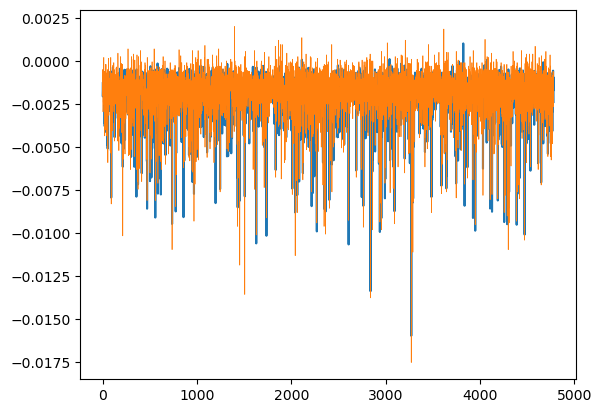

In [206]:
plt.plot(preds_rf)
plt.plot(y_test.reset_index(drop=True), linewidth=0.5)

In [214]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
preds_knn = knn.predict(X_test)
mae = mean_absolute_error(preds_knn, y_test)
mape = mean_absolute_percentage_error(preds_knn, y_test)
print(mae, mape)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f798457a8c0>
Traceback (most recent call last):
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/hanyang/miniconda3/envs/wpcn_env/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


0.0005829644351464446 0.40851015849766925


In [210]:
ens_preds = (preds_knn+preds_rf)/2
ens_mae = mean_absolute_error(ens_preds, y_test)
ens_mape = mean_absolute_percentage_error(ens_preds, y_test)
print(ens_mae, ens_mape)

0.0005636404288702944 0.4014267529856724


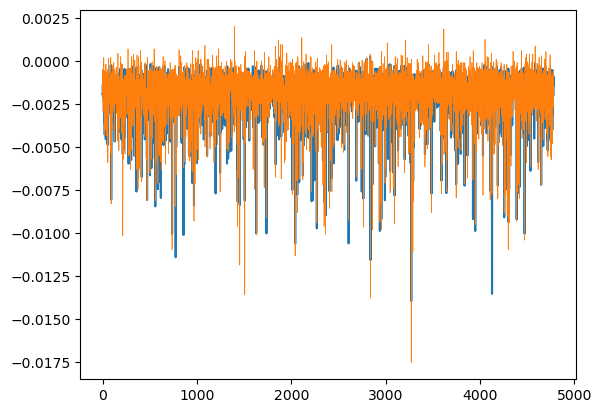

In [204]:
plt.plot(preds)
plt.plot(y_test.reset_index(drop=True), linewidth=0.5)

In [ ]:
def make_train_test_split(non_zero_columns, selected_features_continuous):
    try:
        X = nonzero_columns[selected_features_continuous].copy()
    except Exception as e:
        print(e)
        pass

    # scaler = StandardScaler()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = segment["total_vol_diff"].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:
# Define the Neural Network
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 64)  # Increased number of neurons
        self.bn1 = nn.BatchNorm1d(64)           # Batch normalization
        self.dropout1 = nn.Dropout(0.2)         # Dropout
        self.fc3 = nn.Linear(64, 1)             # 2 inputs, 1 output

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc3(x)
        return x

def net_pipeline(X_train, y_train, X_test, y_test, epochs):
    net = Net(X_train.shape[1])

    # Define the Loss Function and Optimizer
    criterion = nn.MSELoss()
    # optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)
    # optimizer = optim.Adadelta(net.parameters()) # 0.02
    # optimizer = optim.Adagrad(net.parameters()) # 0.0018
    # optimizer = optim.AdamW(net.parameters()) # 0.0008
    # optimizer = optim.SparseAdam(net.parameters()) # Doesnt work
    # optimizer = optim.Adamax(net.parameters()) #0.002
    # optimizer = optim.ASGD(net.parameters()) # 0.00077
    # optimizer = optim.NAdam(net.parameters()) # 0.00078
    # optimizer = optim.RAdam(net.parameters()) #  0.00077
    # optimizer = optim.RMSprop(net.parameters()) # 0.0049
    optimizer = optim.Rprop(net.parameters()) # 0.00072
    # optimizer = optim.SGD(net.parameters(), lr=0.01) # 0.00077

    # Example Data (you will replace this with your actual data)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Convert X to a PyTorch tensor
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Convert y to a PyTorch tensor
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Convert X to a PyTorch tensor
    inputs = X_train_tensor
    targets = y_train_tensor

    # Training the Network
    for epoch in range(epochs):  # number of times to loop over the dataset
        optimizer.zero_grad()   # zero the parameter gradients
        outputs = net(inputs)   # forward pass
        loss = criterion(outputs, targets) # calculate the loss
        loss.backward()         # backward pass
        optimizer.step()        # optimize

        if epoch % 10 == 0:    # print every 100 epochs
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    with torch.no_grad():
        test_input = X_test_tensor # Example voltage input
        predicted = net(test_input)
        mae = mean_absolute_error(y_test, predicted)
    return mae

net_pipeline(X_train_, y_train_.values.reshape(-1,1), X_test_, y_test_.values.reshape(-1,1), epochs=20000)

Epoch 0, Loss: 0.271572083234787
Epoch 10, Loss: 0.03578702360391617
Epoch 20, Loss: 0.015133733861148357
Epoch 30, Loss: 0.004763653967529535
Epoch 40, Loss: 0.0026631138753145933
Epoch 50, Loss: 0.0012766591971740127
Epoch 60, Loss: 0.0008016688516363502
Epoch 70, Loss: 0.0006515636923722923
Epoch 80, Loss: 0.0003943667106796056
Epoch 90, Loss: 0.0002861742686945945
Epoch 100, Loss: 0.00020904011034872383
Epoch 110, Loss: 0.00014370617282111198
Epoch 120, Loss: 0.00010327320342184976
Epoch 130, Loss: 8.438598888460547e-05
Epoch 140, Loss: 5.8891906519420445e-05
Epoch 150, Loss: 5.327764301910065e-05
Epoch 160, Loss: 4.2524894524831325e-05
Epoch 170, Loss: 3.268221553298645e-05
Epoch 180, Loss: 2.4841323465807363e-05
Epoch 190, Loss: 1.9563141904654913e-05
Epoch 200, Loss: 1.612707092135679e-05
Epoch 210, Loss: 1.4410250514629297e-05
Epoch 220, Loss: 1.2375936421449296e-05
Epoch 230, Loss: 1.0540236871747766e-05
Epoch 240, Loss: 9.219637831847649e-06
Epoch 250, Loss: 7.765261216263752

0.0008014385447922361

In [111]:
y_train.values.reshap

array([-0.0023 , -0.0005 , -0.0029 , ..., -0.00065, -0.0005 , -0.0018 ])

array([[-0.0023 ],
       [-0.0005 ],
       [-0.0029 ],
       ...,
       [-0.00065],
       [-0.0005 ],
       [-0.0018 ]])

In [66]:
results_df

,corr,rfr,gbr,combined
lr,0.000799,0.000799,0.000799,0.000799
lasso,0.000859,0.000859,0.000859,0.000859
ridge,0.000799,0.000799,0.000799,0.000799
bayesian_ridge,0.000799,0.000799,0.000799,0.000799
elasticnet,0.000799,0.000799,0.000799,0.000799
DT,0.000725,0.000727,0.000726,0.000723
RF,0.000560,0.000561,0.000563,0.000559
xgb,0.000613,0.000613,0.000613,0.000613
lgbm,0.000621,0.000621,0.000621,0.000621
gpr,0.001394,0.001394,0.001394,0.001394


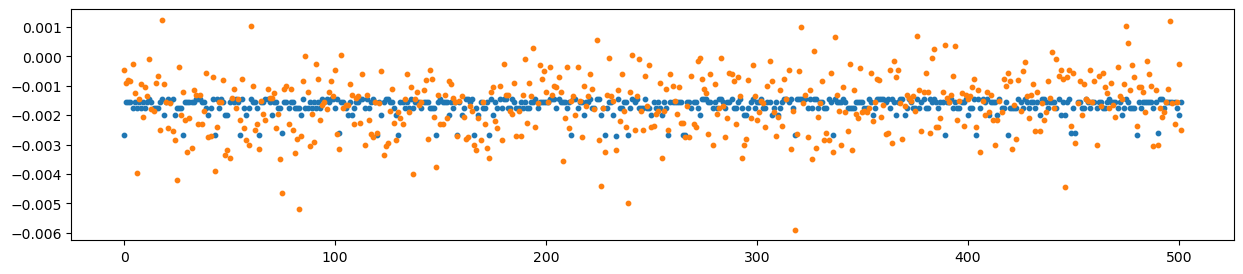

In [61]:
plt.figure(figsize=(15, 3))
plt.scatter(range(len(pred)), pred, s=10)
plt.scatter(range(len(pred)), y_test.reset_index(drop=True), s=10)